# Federated Learning

In [1]:
import logging
import shutil
from collections import OrderedDict
from pathlib import Path
from typing import Dict, Optional, Tuple
import wandb

import lightning as L
import matplotlib.pyplot as plt
import torch
from datasets.utils.logging import disable_progress_bar
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Context, NDArrays, Scalar, ndarrays_to_parameters
from flwr.server import ServerApp, ServerAppComponents, ServerConfig
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets.visualization import plot_label_distributions
from lightning.pytorch.callbacks import (EarlyStopping, ModelCheckpoint,
                                         TQDMProgressBar)
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader

from dataset_utils import Cinc2017DataModuleFL
from model import DenseNet1dModule, DenseNet1dModuleFL

/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-30 04:55:35,234	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# disable unnecessary logging on the server side
logging.getLogger("lightning.pytorch.utilities.rank_zero").disabled = True
logging.getLogger("lightning.pytorch.accelerators.cuda").disabled = True
disable_progress_bar()

# remove old client log files
shutil.rmtree(Path("logs/federated_client"), ignore_errors=True)

## Config

In [3]:
NUM_CLIENTS = 5
NUM_ROUNDS = 20
MAX_EPOCHS = 10
BATCH_SIZE = 64
NON_IID = True
PROXIMAL_MU = 0

## Logging

In [4]:
wandb.init(
    project="ecg-federated",
    name="ecg-federated",
    dir="wandb_logs",
    config={
        "NUM_CLIENTS": NUM_CLIENTS,
        "NUM_ROUNDS": NUM_ROUNDS,
        "MAX_EPOCHS": MAX_EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,
        "NON_IID": NON_IID,
        "PROXIMAL_MU": PROXIMAL_MU,
    },
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: devilhyt. Use `wandb login --relogin` to force relogin
/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:84: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


## Dataset

In [ ]:
dm = Cinc2017DataModuleFL(batch_size=BATCH_SIZE, num_partitions=NUM_CLIENTS)
dm.setup("client", NON_IID, 0.5)

# dataloaders for server side evaluation
dm.setup("train_eval")
train_loader = dm.train_eval_dataloader()
dm.setup("validate")
valid_loader = dm.val_dataloader()

## Data Distribution For Each Client

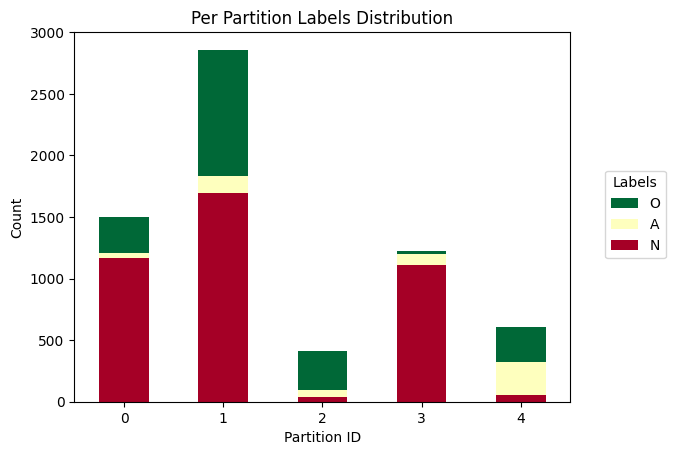

In [6]:
fig, ax, df = plot_label_distributions(
    dm.client_set_partitioner,
    label_name="label",
    plot_type="bar",
    size_unit="absolute",
    partition_id_axis="x",
    legend=True,
    verbose_labels=True,
    title="Per Partition Labels Distribution",
)
plt.show()

## Flower Client App

In [7]:
def get_parameters(model: DenseNet1dModule) -> list:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]


def set_parameters(model: DenseNet1dModule, parameters):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

In [8]:
class FlowerClient(NumPyClient):
    def __init__(
        self,
        context: Context,
        train_dataloader: DataLoader,
        valid_dataloader: DataLoader,
        max_epochs: int,
    ):
        # disable unnecessary logging for each client
        logging.getLogger("lightning.pytorch.utilities.rank_zero").disabled = True
        logging.getLogger("lightning.pytorch.accelerators.cuda").disabled = True

        self.model = None
        self.m_context = context
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.max_epochs = max_epochs

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        default_root_dir = Path(
            f"logs/federated_client/client_{self.m_context.node_id}"
        )
        lr = config["lr"]
        
        # self.model = DenseNet1dModule(
        #     num_classes=dm.num_classes,
        #     show_valid_cm=False,
        #     memory_efficient=False,
        #     lr=lr,
        # )
        self.model = DenseNet1dModuleFL(
            num_classes=dm.num_classes,
            show_valid_cm=False,
            memory_efficient=False,
            lr=lr,
            proximal_mu=config["proximal_mu"],
        )

        # remove previous round log files
        # shutil.rmtree(default_root_dir, ignore_errors=True)

        # get the global model from the server
        set_parameters(self.model, parameters)

        # define trainer
        # checkpoint_callback = ModelCheckpoint(
        #     monitor="valid_loss",
        #     mode="min",
        #     save_top_k=1,
        #     save_last=False,
        #     enable_version_counter=False,
        # )
        # early_stopping_callback = EarlyStopping(
        #     monitor="valid_loss", patience=8, mode="min"
        # )

        trainer = L.Trainer(
            max_epochs=self.max_epochs,
            enable_progress_bar=False,
            enable_model_summary=False,
            logger=False,
            # callbacks=[checkpoint_callback, early_stopping_callback],
            enable_checkpointing=False,
            default_root_dir=default_root_dir,
        )

        # train the model
        trainer.fit(self.model, self.train_dataloader, self.valid_dataloader)

        # return the best model to the server
        # best_model = DenseNet1dModuleFL.load_from_checkpoint(
        #     checkpoint_callback.best_model_path
        # )
        # print(checkpoint_callback.best_model_path)
        return get_parameters(self.model), len(self.train_dataloader.dataset), {}


def client_fn(context: Context) -> Client:
    """Construct a Client that will be run in a ClientApp."""

    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    train_dataloader, valid_dataloader = dm.client_dataloaders(partition_id)

    # Read run_config to fetch hyperparameters relevant to this run
    return FlowerClient(
        context, train_dataloader, valid_dataloader, MAX_EPOCHS
    ).to_client()


client_app = ClientApp(client_fn=client_fn)

## Flower Server App

In [9]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    """Server-side parameter evaluation"""
    default_root_dir = Path("logs/federated_server")

    model = DenseNet1dModule(num_classes=dm.num_classes, memory_efficient=False)
    set_parameters(model, parameters)  # Update model with the latest parameters

    trainer = L.Trainer(
        enable_progress_bar=False, enable_model_summary=False, logger=False
    )

    # Evaluate on the train set
    # We place train evaluation on the server side for convenience.
    # In a real-world scenario, this should be done on the client side.
    train_result = trainer.validate(model, train_loader, verbose=False)[0]
    for key in ["loss", "acc", "f1"]:
        train_result[f"train_{key}"] = train_result.pop(f"valid_{key}")
    wandb.log(train_result, step=server_round)

    # Evaluate on the valid set
    valid_result = trainer.validate(model, valid_loader, verbose=False)[0]
    wandb.log(valid_result, step=server_round)

    result = {**train_result, **valid_result}

    # Save the model checkpoint
    # trainer.save_checkpoint(default_root_dir / f"model_round_{server_round}.ckpt")
    trainer.save_checkpoint(default_root_dir / f"model_round_last.ckpt")
    return valid_result["valid_loss"], result


def fit_config(server_round: int):
    lr = 1e-3 * 0.5 ** (server_round // 8)
    config = {
        "server_round": server_round,
        "lr": lr,
    }
    wandb.log({"learning_rate": lr})
    return config


def server_fn(context: Context) -> ServerAppComponents:
    """Construct components for ServerApp."""

    # Convert model parameters to flwr.common.Parameters
    init_model = DenseNet1dModule(num_classes=dm.num_classes, memory_efficient=False)
    ndarrays = get_parameters(init_model)
    initial_parameters = ndarrays_to_parameters(ndarrays)

    # Define strategy
    # strategy = FedAvg(
    #     fraction_fit=1.0,
    #     fraction_evaluate=0,
    #     min_fit_clients=NUM_CLIENTS,
    #     min_available_clients=NUM_CLIENTS,
    #     initial_parameters=initial_parameters,
    #     evaluate_fn=evaluate,
    #     on_fit_config_fn=fit_config,
    # )
    strategy = FedProx(
        fraction_fit=1.0,
        fraction_evaluate=0,
        min_fit_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=initial_parameters,
        evaluate_fn=evaluate,
        on_fit_config_fn=fit_config,
        proximal_mu=PROXIMAL_MU,
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config=config)


server_app = ServerApp(server_fn=server_fn)

## Run Simulation

In [10]:
backend_config = {
    "client_resources": {"num_cpus": 1, "num_gpus": 1 / (NUM_CLIENTS + 1)}
}

# Run simulation
run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.9631854295730591, {'train_loss': 0.961961567401886, 'train_acc': 0.3333333432674408, 'train_f1': 0.25393250584602356, 'valid_loss': 0.9631854295730591, 'valid_acc': 0.3333333432674408, 'valid_f1': 0.25406351685523987}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      fit progress: (1, 0.8308319449424744, {'train_loss': 0.806323766708374, 'train_acc': 0.47564947605133057, 'train_f1': 0.4038085341453552, 'valid_loss': 0.8308319449424744, 'valid_acc': 0.43949443101882935, 'valid_f1': 0.3760335147380829}, 91.61172272799968)
INFO :      configure_evaluate: no clients selected, skipp

(raylet) The node with node id: 16192aada335fc72130bb211ccb6fb0ecc2fb1e389cd2093c1d72976 and address: 140.120.13.231 and node name: 140.120.13.231 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, preempted node, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.


(ClientAppActor pid=214987) Traceback (most recent call last):
(ClientAppActor pid=214987)   File "python/ray/_raylet.pyx", line 2025, in ray._raylet.execute_task
(ClientAppActor pid=214987)   File "python/ray/_raylet.pyx", line 2065, in ray._raylet.execute_task
(ClientAppActor pid=214987)   File "python/ray/_raylet.pyx", line 4590, in ray._raylet.CoreWorker.store_task_outputs
(ClientAppActor pid=214987)   File "python/ray/_raylet.pyx", line 4477, in ray._raylet.CoreWorker.store_task_output
(ClientAppActor pid=214987)   File "python/ray/_raylet.pyx", line 589, in ray._raylet.check_status
(ClientAppActor pid=214987) ray.exceptions.RaySystemError: System error: Broken pipe
(ClientAppActor pid=214987) During handling of the above exception, another exception occurred:
(ClientAppActor pid=214987) Traceback (most recent call last):
(ClientAppActor pid=214987)   File "python/ray/_raylet.pyx", line 2281, in ray._raylet.task_execution_handler
(ClientAppActor pid=214987)   File "python/ray/_ray

## Evaluation and Visualization on the Test set.

In [11]:
progress_bar_callback = TQDMProgressBar(leave=True)

trainer = L.Trainer(
    callbacks=[progress_bar_callback],
    logger=False,
)

In [12]:
model = DenseNet1dModule.load_from_checkpoint(
    Path(f"logs/federated_server/model_round_last.ckpt")
)

result = trainer.test(model, datamodule=dm)
print(result)
wandb.log(result[0])

Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 40.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8001526594161987     │
│          test_f1          │    0.7982633113861084     │
│         test_loss         │    0.6207807064056396     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6207807064056396, 'test_acc': 0.8001526594161987, 'test_f1': 0.7982633113861084}]


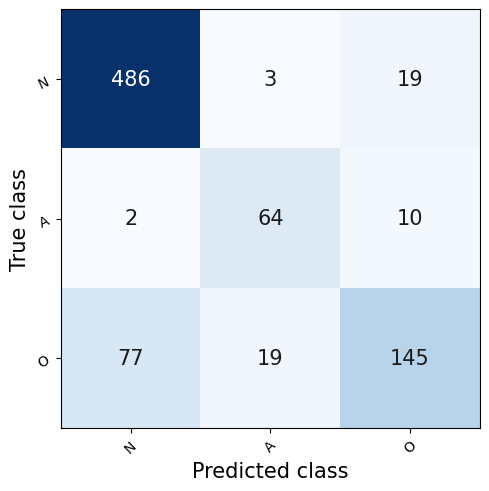

In [13]:
fig, ax = model.test_cm.plot(model.test_cm_log, cmap="Blues", labels=dm.test_set.classes)
plt.show()
wandb.log({"test_cm": fig})

In [14]:
wandb.finish()

/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/wandb/sdk/lib/ipython.py:84: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import HTML, display  # type: ignore


learning_rate,███████▃▃▃▃▃▃▃▃▁▁▁▁▁
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▃▇▇▇▇▇██████████████
train_f1,▁▃▇▇▇▇▇██████████████
train_loss,█▆▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_acc,▁▃▇██████████████████
valid_f1,▁▃▇██████████████████
valid_loss,█▆▃▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
learning_rate,0.00025
